In [27]:
from transformers import ViTImageProcessor, ViTForImageClassification, ViTModel, ViTConfig
from maskgen.vision_models.vision_maskgen import MaskGeneratingModel, convert_to_peft
from maskgen.utils import get_preprocess, collate_fn, load_imagenet
# from maskgen.utils.img_utils import plot_overlap_np
from torch.utils.data import DataLoader
import torch
import json
import os
from tqdm import tqdm
import numpy as np
from typing import Dict, Any

def load_config(config_path: str) -> Dict[str, Any]:
    """Load configuration from JSON file."""
    with open(config_path, 'r') as f:
        config = json.load(f)
    
    # Flatten config for easier access
    flat_config = {}
    flat_config.update(config['evaluation'])
    flat_config.update(config['model'])
    flat_config.update(config['dataset'])
    
    return flat_config


In [28]:
from maskgen.utils import load_imagenet
from maskgen.utils.model_utils import get_pred_model
# Load configuration
config = load_config('eval_config.json')

# Create results directory if it doesn't exist
if not os.path.exists(config['results_path']):
    os.makedirs(config['results_path'])

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Model
pretrained_name = config['pretrained_name']
processor, target_model = get_pred_model(pretrained_name, device)
vit_config = target_model.config

# Get image normalization parameters
img_mean = processor.image_mean
img_std = processor.image_std

# Target model for explanation
target_model = ViTForImageClassification.from_pretrained(pretrained_name)
target_model.eval()
target_model.to(device)

# Load trained weights
maskgen_model = MaskGeneratingModel.load_model(base_model_name=pretrained_name, 
                                save_path=config['model_path'], 
                                hidden_size=vit_config.hidden_size, 
                                num_classes=vit_config.num_labels)
maskgen_model.eval()
maskgen_model.to(device)

print() 

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Converted base model layers to PEFT: ['encoder.layer.0.attention.attention.query', 'encoder.layer.0.attention.attention.key', 'encoder.layer.0.attention.attention.value', 'encoder.layer.0.attention.output.dense', 'encoder.layer.0.intermediate.dense', 'encoder.layer.0.output.dense', 'encoder.layer.1.attention.attention.query', 'encoder.layer.1.attention.attention.key', 'encoder.layer.1.attention.attention.value', 'encoder.layer.1.attention.output.dense', 'encoder.layer.1.intermediate.dense', 'encoder.layer.1.output.dense', 'encoder.layer.2.attention.attention.query', 'encoder.layer.2.attention.attention.key', 'encoder.layer.2.attention.attention.value', 'encoder.layer.2.attention.output.dense', 'encoder.layer.2.intermediate.dense', 'encoder.layer.2.output.dense', 'encoder.layer.3.attention.attention.query', 'encoder.layer.3.attention.attention.key', 'encoder.layer.3.attention.attention.value', 'encoder.layer.3.attention.output.dense', 'encoder.layer.3.intermediate.dense', 'encoder.layer

Predicted class: projector


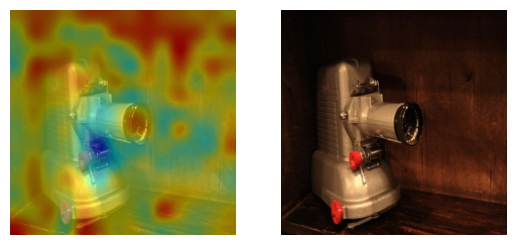

In [33]:
import requests
from PIL import Image
from maskgen.utils.img_utils import plot_overlap_np
from maskgen.utils.image_utils import get_image_example

image = get_image_example(9)

with torch.no_grad():
    inputs = processor(images=image, return_tensors="pt")
    inputs.to(device)
    img = inputs['pixel_values']
    img = img.to(device)
    predicted_class_idx = target_model(img).logits.argmax(-1).item()
    secondary_class_idx = target_model(img).logits.argsort(descending=True)[0][1].item()

label = predicted_class_idx
# label = secondary_class_idx
label = torch.tensor([label]).to(device)

print("Predicted class:", target_model.config.id2label[label.item()])

# heatmap = torch.sigmoid(sim_logits).reshape(N, size, size)
heatmap = maskgen_model.attribute_img(img, label.unsqueeze(1), image_size=224, patch_size=16)
# heatmap = sim_logits.reshape(N, size, size)

heatmap = heatmap.squeeze(0).detach().cpu().numpy()
img = img.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)
img_int, heatmap_img = plot_overlap_np(img, heatmap, img_mean, img_std)

In [30]:
print(heatmap.max(), heatmap.min())

0.5397748 0.26356176


In [31]:
heatmap

array([[0.30239838, 0.37024292, 0.32186455, 0.34932446, 0.33504432,
        0.37330258, 0.36887142, 0.38781026, 0.35404077, 0.30134085,
        0.3201196 , 0.26645556, 0.30191484, 0.3204517 ],
       [0.3533612 , 0.33901414, 0.35841465, 0.34090444, 0.35300973,
        0.3727261 , 0.49319455, 0.32265738, 0.31561834, 0.28104785,
        0.29322067, 0.49359486, 0.27073646, 0.28658068],
       [0.33266783, 0.32013354, 0.29563442, 0.3805548 , 0.36712757,
        0.35600027, 0.31213918, 0.3481549 , 0.36966214, 0.2837646 ,
        0.4943647 , 0.26730385, 0.30125183, 0.29207432],
       [0.36357433, 0.3614609 , 0.49424577, 0.32735062, 0.38597614,
        0.49446893, 0.40493357, 0.38992697, 0.38326496, 0.3481318 ,
        0.4942376 , 0.33592877, 0.27441612, 0.30047876],
       [0.3061839 , 0.32746243, 0.3480503 , 0.39429224, 0.4063026 ,
        0.42484877, 0.39458644, 0.39127284, 0.41104606, 0.3813352 ,
        0.49493185, 0.341916  , 0.26356176, 0.28841475],
       [0.3438258 , 0.3354269 , 0.3